# CYPLAN255
### Urban Informatics and Visualization

HIT RECORD and TRANSCRIBE

# Lecture 18 -- Making maps
******
March 28, 2022

<img src="https://pbs.twimg.com/media/EWZOf79X0AYkKwh?format=jpg&name=large" width=500 align='right' title='1928 The house band for the Michelin Radio hour. c. 1928'>

# Agenda
1. Announcements
2. Static maps
3. Project breakout groups
4. For next time
5. Questions


# 1. Announcements

- Submit your final project groups by Sunday!
- I will be randomly assigning presentation days accordingly.

# 2. Static Maps

Imports

In [1]:
import pandas as pd
import geopandas as gpd
import geoplot
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

Let's grab some data we've already worked with

In [2]:
storefronts = gpd.read_file('https://github.com/dillonma/storefrontindex/raw/master/all56_nACSxMSA__41860.0.geojson')
tracts = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_06_tract10.zip")
tracts = tracts[tracts['COUNTYFP10'].isin(['001', '013', '041', '075', '081'])]

## 2.1. GeoPandas

This section should mostly be review. If you're feeling lost, refer back to the lecture 13 and 14 notebooks.

### 2.1.1. Point Plot

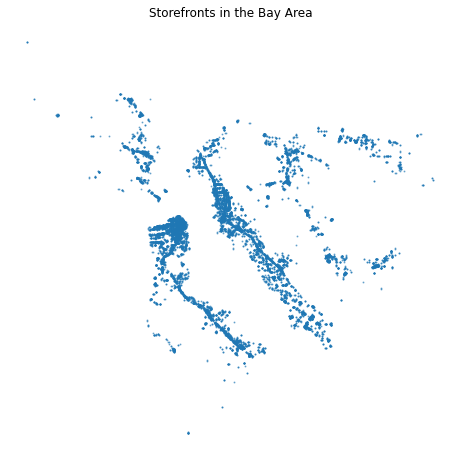

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))
storefronts.plot(markersize=1, ax=ax, alpha=0.5)
ax.axis('off')
ax.set_title("Storefronts in the Bay Area")
plt.show()

### 2.1.2. Adding Data Layers

The biggest single improvement we can make is probably to add in the coastline, which will give people familiar with the Bay Area a clearer sense of what they're looking at.

Remember, when dealing with multiple layers of geospatial data, you'll need to make sure that the CRS's match!  jff -- make sure the coordinate reference systems line up!

**Useful sources for background data**

When you start visualizing geosptial data, all of a sudden you have to find appropriate *background* datasets to include in your maps: country borders, states, counties, etc. 

[Natural Earth](https://www.naturalearthdata.com), mentioned above, is a nice resource for this. So is the U.S. Census [TIGER](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html) data. That stands for Topologically Integrated Geographic Encoding and Referencing, obviously.

Generally, you want to look for what's called "cartographic" shapefiles for this: not the administrative boundaries, which might extend out into the ocean, but the common-sense boundaries that people are most familiar with.

In [4]:
outlines = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_500k.zip')
outlines = outlines[outlines['GEOID'] == '06']  # just CA  #filtering out everything that is not CA

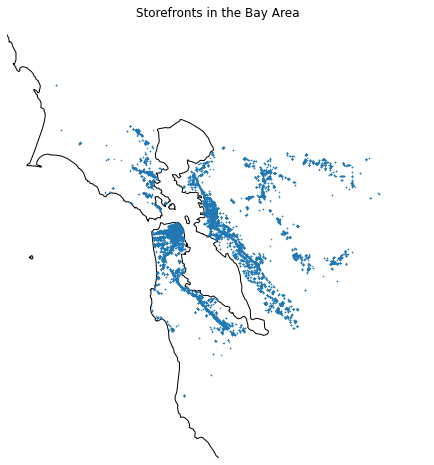

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
outlines.plot(ax=ax, facecolor='none')
storefronts.to_crs(outlines.crs).plot(markersize=1, ax=ax, marker='.') #same storefront plot, but converting it to the CRS of the outline shapefiles 
ax.set_title("Storefronts in the Bay Area")


#using the actual extent of the data to limit the extent of the CA map; like zooming
#into the Bay Area. Definitning the limits of the x axis and the y axis, but including a buffer 
#so the dots don't show up in the very corner of the map.
buff = .2
ax.set_xlim(storefronts['geometry'].x.min() - buff, storefronts['geometry'].x.max() + buff)
ax.set_ylim(storefronts['geometry'].y.min() - buff, storefronts['geometry'].y.max() + buff)
ax.axis('off')
plt.show()  #lots of dots are on top of each other, so hard ti infer the actual distribution
#of points. COuld play with transparency to try to improve it, but if points are unevenly
#distributed then hard to see it.

### 2.1.3. Basic Choropleth

In [6]:
storefronts.index.name = 'storefront_id'
storefronts.reset_index(inplace=True)  

In [7]:
#performing a spatial join of storefronts onto the tracts
tracts_w_stores = gpd.sjoin(storefronts, tracts.to_crs(storefronts.crs), how='inner', predicate='within')
tract_counts = tracts_w_stores.groupby('GEOID10')['storefront_id'].count().reset_index() #aggregating data by tract ID and counting number of stores
tracts = pd.merge(tracts, tract_counts, on='GEOID10', how='left') 
tracts['store_count'] = tracts['storefront_id'].fillna(0)
tracts = tracts.clip(outlines.to_crs(tracts.crs))  # clip tract geoms to coastline

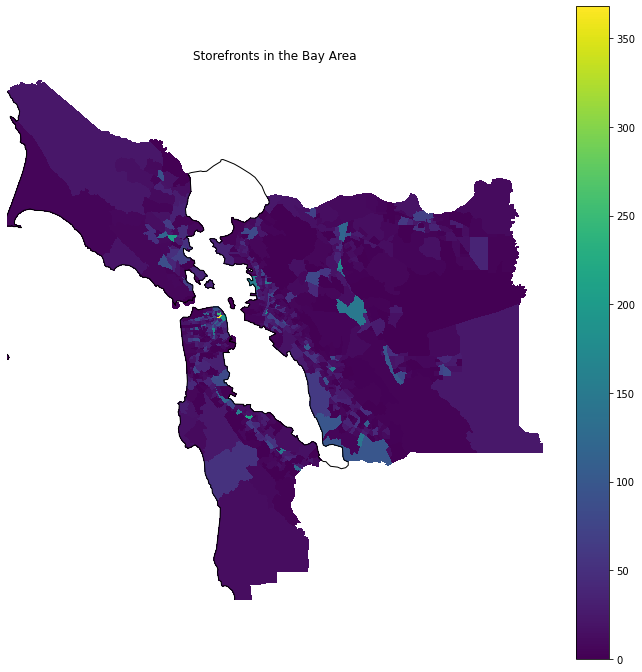

In [8]:
fig, ax = plt.subplots(figsize=(12, 12))

tracts.plot(
    column='store_count',
    ax=ax,
    legend=True,
    antialiased=False   #if didn't include this, would see the outlines of the tracts. Up to you if you want to include them. Stylistic choice.
    
)
outlines.plot(ax=ax, facecolor='none') 
ax.set_title("Storefronts in the Bay Area")

buff = .1
ax.set_xlim(storefronts['geometry'].x.min() - buff, storefronts['geometry'].x.max() + buff)
ax.set_ylim(storefronts['geometry'].y.min() - buff, storefronts['geometry'].y.max() + buff)
ax.axis('off')
plt.show()

#what's wrong with this map? Looks very purple in places where people don't really live.

### 2.1.3. Normalize by Unit Area

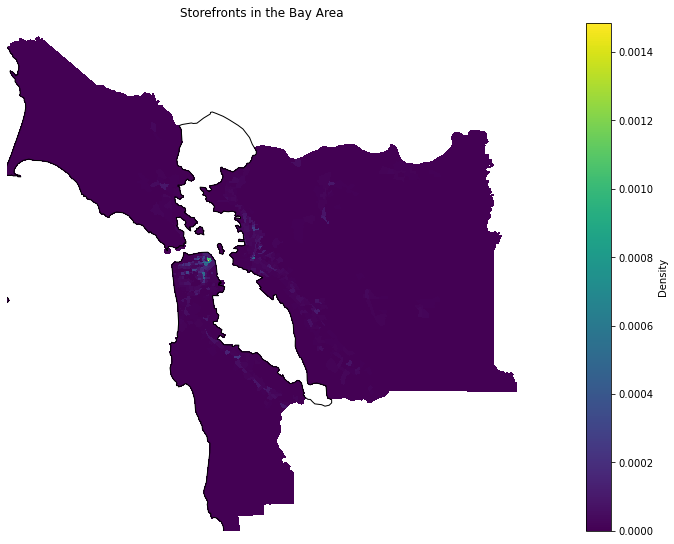

In [9]:
#improves the map by normalizing over unit area, but still very dark colors, so could continue to tweak

fig, ax = plt.subplots(figsize=(12, 12))

tracts['store_density'] = tracts['store_count'] / tracts['ALAND10']

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)

tracts.plot(
    column='store_density',
    edgecolor='none',
    ax=ax,
    cax=cax, 
    legend=True,
    legend_kwds={'label': 'Density'},
    antialiased=False
)
outlines.plot(ax=ax, facecolor='none', )
ax.set_title("Storefronts in the Bay Area")

buff = .1
ax.set_xlim(storefronts['geometry'].x.min() - buff, storefronts['geometry'].x.max() + buff)
ax.set_ylim(storefronts['geometry'].y.min() - buff, storefronts['geometry'].y.max() + buff)

ax.axis('off')

plt.show()

### 2.1.4. Alternative Classification Schemes

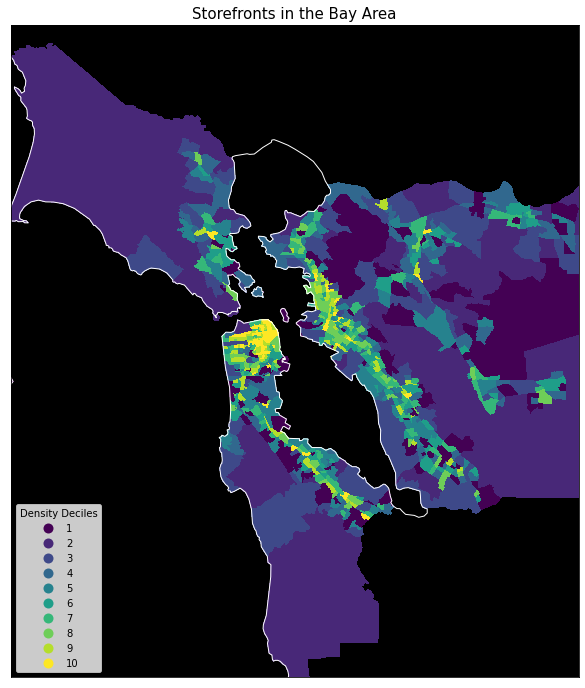

In [10]:
#another idea is to change the classification scheme. so instead of changing the density, 
#change the scale, change the bin sizes. If you don't specify, the default is equal distance bins. So if you 
#pick the viridis color scheme that goes from dark blue to bright yellow, the default is to
#divide that scheme into 5 colors with 4 breakpoints, equidistant, and then it just assigns colors
#to each geometry. But if you are working with heavily skewed data like this,
#where linear classification scheme doesn't work as well with equal break points,
#you can visualize the varition in density using different classification schemes.
#this is where it becomes really easy to lie with the data though, so be ethical!!

fig, ax = plt.subplots(figsize=(12, 12))

tracts.plot(
    column='store_density',
    edgecolor='none',
    lw=.01,
    ax=ax,
    k=10,  # number of bins
    scheme='quantiles',  # choropleth classification scheme #defining bins so equal number of observations per bin
    legend=True,
    legend_kwds={
        'title': 'Density Deciles',
        'loc':'lower left',
        'labels': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    },
    antialiased=False  # turn off 

)
outlines.plot(ax=ax, facecolor='none', edgecolor='white')
ax.set_title("Storefronts in the Bay Area", fontsize=15)

buff = .1
ax.set_xlim(storefronts['geometry'].x.min() - buff, storefronts['geometry'].x.max() - buff)
ax.set_ylim(storefronts['geometry'].y.min() - buff, storefronts['geometry'].y.max() + buff)
ax.set_facecolor('k')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

#does a better job of highlighting the spatial variation, but also gives a different impression about
#the way that these storefronts are distributed in space. Same exact data, just 
#a different way of categorizing the tracts, in this case. Includes a legend that makes it 
#clear what's being displayed, but from a purely informational perspective, this
#map tells us less about how the storefronts are actually distributed in space.
#makes it easier to compare differences between neighboring census tracts, but as a whole
#doesn't do as good a job at representing how the storefronts are actually distributed.

### Exercises
Geopandas uses a library called `mapclassify` to implement the choropleth classification schemes. Check out the documentation here for all of the available options: https://pysal.org/mapclassify/api.html
1. Try implementing two different classifaction schemes. 
2. Try using quantiles to visualize the original storefront counts (not densities). How does it compare to the density quantiles?

In [11]:
#below, can hit shift-tab next to quantiles and see other possible schemes that draw on geopandas' mapclassify library. Will need to play around with the bins and labels probably
#to make other options work

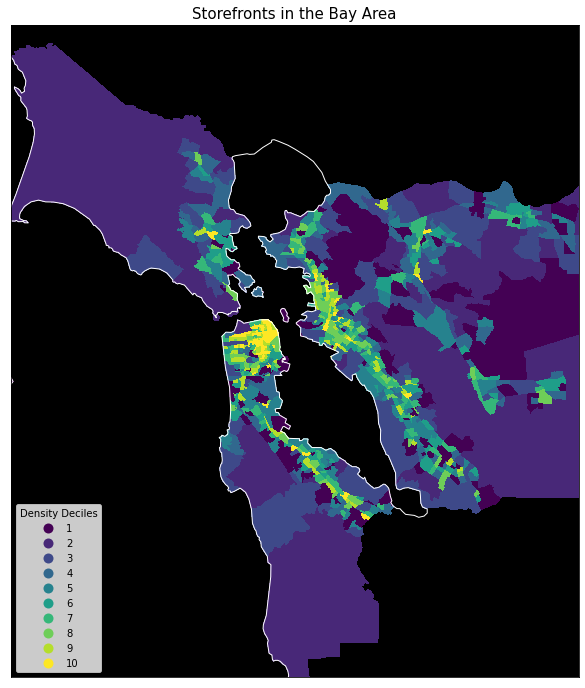

In [12]:
fig, ax = plt.subplots(figsize=(12, 12))

tracts.plot(
    column='store_density',
    edgecolor='none',
    lw=.01,
    ax=ax,
    k=10,  # number of bins
    scheme='quantiles',  # choropleth classification scheme #defining bins so equal number of observations per bin
    legend=True,
    legend_kwds={
        'title': 'Density Deciles',
        'loc':'lower left',
        'labels': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    },
    antialiased=False  # turn off 

)
outlines.plot(ax=ax, facecolor='none', edgecolor='white')
ax.set_title("Storefronts in the Bay Area", fontsize=15)

buff = .1
ax.set_xlim(storefronts['geometry'].x.min() - buff, storefronts['geometry'].x.max() - buff)
ax.set_ylim(storefronts['geometry'].y.min() - buff, storefronts['geometry'].y.max() + buff)
ax.set_facecolor('k')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

## 2.2. Map tiles

You are probably a lot more familiar with **map tiles** than you think. If you have ever used Google Maps, Apple Maps, Bing Maps, OpenStreetMap, you have used map tiles. Broadly speaking, map tiles are how interactive maps get rendered on the web. It's the technology that lets you quickly pan and zoom around a map without the images appearing blurry at high zoom levels, or overcrowded at low zoom levels.

For two great overviews of map tiles, how they work, and how they enable pretty much ever web map you've ever seen, check out these two blog posts:
 - http://www.liedman.net/tiled-maps/
 - https://www.axismaps.com/guide/what-is-a-web-map

Map tiles are in essence nothing more than a very efficient data structure for dividing a map data/imagery into a hierarchical grid. Tiles have become the industry standard for web mapping because they allow your browser to query, download, and render only the portion of the map/data you need at the moment you need it. 

In [13]:
#map tiles allow for smooth zooming in and out on web-based maps. Check out the blog
#posts he included above

|<center> Zoom Level 2</center>| <center>Zoom Level 3</center>|
|---|---|
|![](https://uploads-ssl.webflow.com/5f6a4786fa53db61032919f9/5fa45554fb44c1d15e3c7945_zoom2.jpeg)|![](https://uploads-ssl.webflow.com/5f6a4786fa53db61032919f9/5fa45554e24ff53ccf08c7ad_zoom3.jpeg)|

The entire goal of this is to make web maps feel as smooth and responsive as possible when you interact with them, so that they almost feel _animated_. But this is just an illusion. It is all static imagery being intellegently and dynamically rendered.

#they use a "global grid", and then x, y, z coordinates, and then have different zoom levels to ID the global grid tiles at different zoom levels. The tiles nest within in each other. So 4 tiles in Zoom level 3 all fit in one tile in Zoom level 2. 

This means map tile data can be used just as easily for static maps.

### 2.2.1. Static map tile basemaps with `contextily`

In [14]:
import contextily as cx

Contextily is a super useful, super simple library from the PySAL folks for dynamically generating attractive, static basemaps for your `matplotlib` plots. It's really as simple as adding a single line of code to the plots we've already been making. All you have to do is pass the `pyplot` axes object to `cx.add_basemap()`, along with the CRS of the dataset you're plotting.

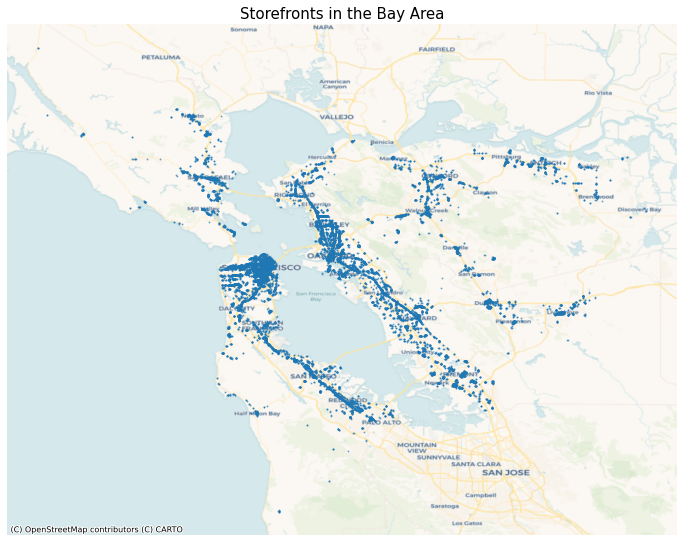

In [15]:
#same code as above, but added the cx.add_basemap line that passed in pyplot object, told it CRS that the data is in,
#and told it what tile provider to use.

fig, ax = plt.subplots(figsize=(12,12))
storefronts.plot(markersize=1, ax=ax, alpha=0.5)
ax.axis('off')
ax.set_title("Storefronts in the Bay Area", fontsize=15)
cx.add_basemap(
    ax,
    crs=storefronts.crs.to_string(),
    source=cx.providers.CartoDB.Voyager) #the map tile "packs" are BIG. At zoom level 2, there may only be 16 images you need to store to cover the world,
#but most go up to zoom level 20 or something, so the nubmer of images at each level grows exponentially. So to store an entire stack of map tiles
#that covers the globe includes a ton of data. So pull only the tiles you need from a database, through an API,
#on demand. The first time you load a map, there's no cache, you're just downloading the tiles you need to visualize
#the portion fo the map you need to visualize your data. Google will probably charge you to use their map tiles, but there are
#a bunch of open source map tile providers. Each has its own style. PLus each provider has its own styles, like more roadmap, thematic maps,
#satellite imagery maptiles, terrain map tiles, etc. YOu can pick and choose depending on what info you want to display.
plt.show()

In the code above, the `source=` argument of `cx.add_basemap()` let's you choose from a number of different map tile providers. Check out the documentation [here](https://contextily.readthedocs.io/en/latest/intro_guide.html#Providers) to see all of the available options.

### Exercise:

Play around with different combinations of matplotlib marker styles (color, shape, opacity) and basemap styles until you find the one you think is best. Does the basemap provide useful context than the coast line shapefile we used before? Or does it add visual noise?

## 2.3. Custom choropleth geometries

In Section 2 above, we used a density metric to avoid the effect of the modifiable areal unit problem in our Census Tract map of storefront counts. As we've seen before, an alternative approach is to define your own equal-area geometries. For simple count data, this is usually the preferred method, since administrative boundaries don't really provide useful context anyways.

### 2.3.1 GeoPandas + Matplotlib Hexbins

This code illustrates how you can mix-and-match map shapes with other kinds of data visualizations and annotations in Matplotlib. It can take a while to work out all the syntax to accomplish things like this, but it's quite powerful.

First we'll need to pull latitude and longitude out into normal DataFrame columns

In [16]:
storefronts['lon'] = storefronts.geometry.x
storefronts['lat'] = storefronts.geometry.y

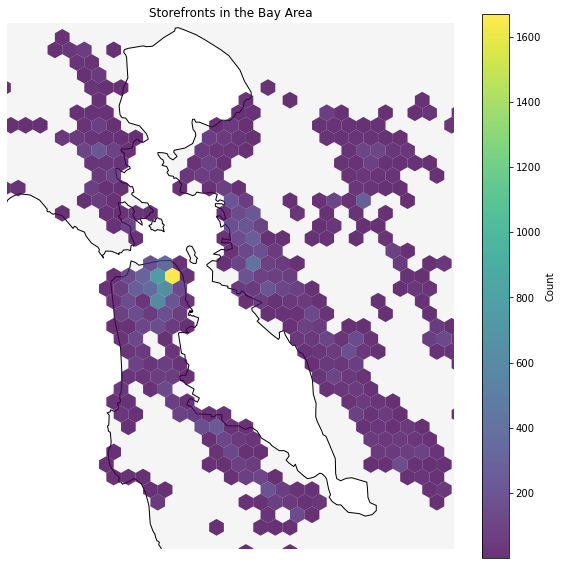

In [17]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot coastline using GeoPandas
outlines.plot(ax=ax, color='whitesmoke', edgecolor='black')

# Plot hexbins of storefronts using Matplotlib  #passed in storefront latitude, storefront longitude. We've seen this before.
hb = plt.hexbin(storefronts.lon, storefronts.lat, mincnt=1, gridsize=50, alpha=.8, lw=0)



# Add a key
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Count')


# Title and bounds
ax.set_title('Storefronts in the Bay Area')
ax.set_xlim((-122.7, -121.9))
ax.set_ylim((37.4, 38.15))

ax.axis('off')
plt.show()   #hexagons are a favored approach of geographers because very efficient space filling shape; also work
#well mathematically if you scale them. Maintains proportions and radii well or something. Best case 
#middle ground between a square and a circle, basically. 

### 2.3.2. Custom hexbins with `h3` and `tobler`

`h3` is an open-source hexagonal geospatial index developed by a ridehailing company. Together, the hexagons define hierarchical **discrete global grid**, meaning it covers the surface of the earth, with no gaps, at multiple levels of resolution.
<center><img src="https://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2018/06/Twitter-H3-768x384.png"></center>


#so the way map tiles above are discrete global grid, here they used hexagons to divide whole surface of the earth into cells with no gaps. h3 is hierarchical, which means there are different levels of resolution with different #s of hexagons in them. You can zoom in and out while maintaining a reasonable number of units of aggregation. 

`h3py` is the official Python binding for using `h3` in Python, which you can find here: https://github.com/uber/h3-py. For this exercise, we're going to use a library called `tobler` instead, but you'll still need to install the underling `h3py` package (`pip install h3`).

`tobler` is another great library from the `PySAL` folks which let's us easily extract h3 geometries using a GeoPandas `GeoDataFrame` object

In [18]:
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate

In [19]:
tracts_proj = tracts.to_crs('epsg:26910') #converting to one of the local CA projected coordinate ref systems

In [20]:
hexes = h3fy(tracts_proj, resolution=7, clip=True)  #h3fy command, passing in tracts, specifying our resolutions, and clipping hexagon geometries to our input data
print(type(hexes)) 

C:\Users\jffin\anaconda3\envs\freshstart\lib\site-packages\tobler\util\util.py:141: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  hexids = pandas.Series(


<class 'geopandas.geodataframe.GeoDataFrame'>


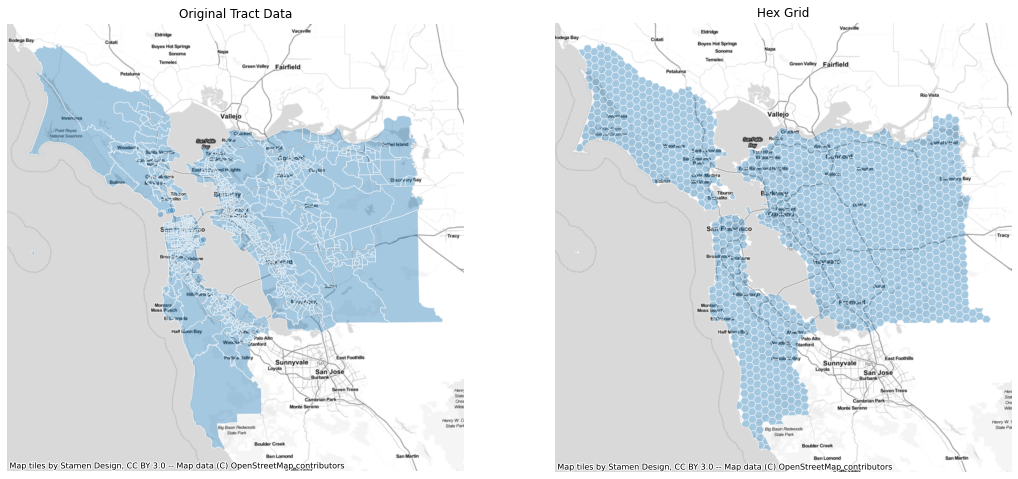

In [21]:
fig, axs = plt.subplots(1,2, figsize=(18,10))
axs=axs.flatten()

tracts_proj.plot(ax=axs[0], alpha=0.4, linewidth=1, edgecolor='white')
hexes.plot(ax=axs[1], alpha=0.4, linewidth=1, edgecolor='white') #comparing tracts to hexagons

axs[0].set_title('Original Tract Data')
axs[1].set_title('Hex Grid')

for i,_ in enumerate(axs):
    cx.add_basemap(   #adding a basemap to each one
        axs[i],
        crs=hexes.crs.to_string(),
        source=cx.providers.Stamen.TonerLite)
    axs[i].axis('off')

Now we can use the same code we used to the tract count map, but with the hexes as our aggregation geometries

In [22]:
#doing similar join as above but using hexagon geometries

hexes = hexes.reset_index()
hexes_w_stores = gpd.sjoin(storefronts, hexes.to_crs(storefronts.crs), how='inner', predicate='within')
hexes_counts = hexes_w_stores.groupby('hex_id')['storefront_id'].count().reset_index()
hexes = pd.merge(hexes, hexes_counts, on='hex_id', how='left')
hexes['store_count'] = hexes['storefront_id'].fillna(0)
hexes = hexes.clip(outlines.to_crs(hexes.crs))  # clip tract geoms to coastline

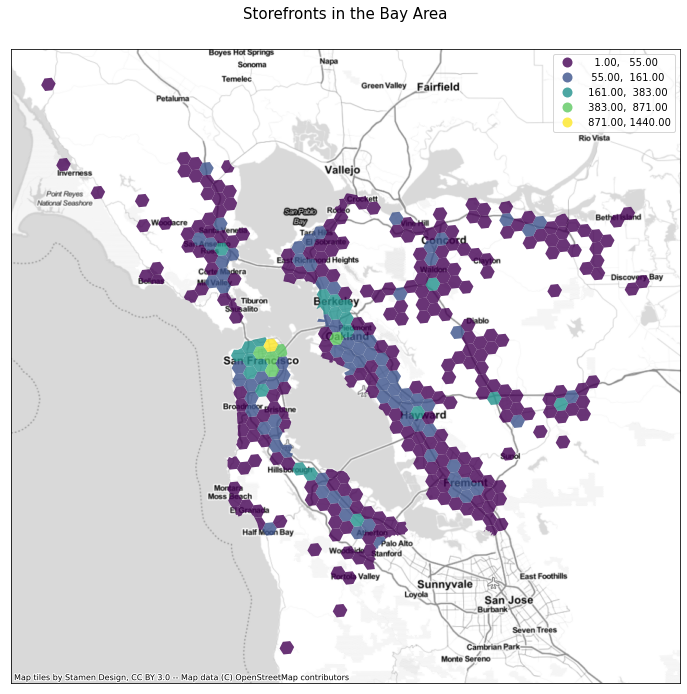

In [23]:
fig, ax = plt.subplots(figsize=(12, 12))

hexes[hexes['store_count'] > 0].plot(
    column='store_count',
    ax=ax,
    legend=True,
    scheme='naturalbreaks',
    alpha=0.8    
)

cx.add_basemap(
    ax,
    crs=hexes.crs.to_string(),
    source=cx.providers.Stamen.TonerLite)
ax.set_title("Storefronts in the Bay Area", fontsize=15, pad=30)

ax.set_xticks([])
ax.set_yticks([])
plt.show()  #this ddisplays more info about how storefronts are allocated. Also automatically generates a legend with the break points.

### Exercise

Try experimenting with different `h3` resolutions and classification schemes!

### 2.3.3. Areal Interpolation

As we've seen, there are many advantages to using exogenously defined, arbitrary geometries to display geospatial data. By aggregating point data to equal-area bins, we can avoid the visual biases imposed by both the plotting of raw points (overlapping, crowded geometries) and administrative boundaries (e.g. MAUP). It is also super straightforward to assign points to polygons, as it will almost always be a one-to-one relationship.

But what about non-point-based data? What if you are using Census data, which is only reported for administrative geometries like Census Tracts and Blocks? 

This would require some kind of mapping of hexbins to administrative boundaries, or vice versa. This can be tricky to do, as it is highly unlikely that the mappings will be one-to-one. More likely, the administrative boundaries will be split across reference geometries, or contain multiple reference geometries, depending on their relative sizes. Additionally, the result might change depending on the kind of spatial join you use to perform the operation (e.g. `contains`, `within`, `touches`, `overlaps`, etc.). The use case for hexbins here is less obvious, but let's go with it for now.

The simplest approach would probably to do an `intersects` operation, but this might return multiple hexbins for each administrative boundary. In this case, you might consider simpling mapping each administrative boundary to the hexbin with which it has the highest degree of overlap.The result might look something like this:

<center><img src="images/hex1.png"></center>

<center><img src="images/hex2.png"></center>

<center><img src="images/hex3.png"></center>

<center><img src="images/hex4.png"></center>

These images might be nice to look at, but they also highlight how messy it can be to map polygons to one another. You'll also still need to aggregate the data from the administrative zones to the hexbins, and clearly some of these aggregations will contain more error than others.

A more rigorous approach would also involve computing the degree of overlap between polygons, but then using that overlap to allocate the data proportionally from the administrative boundaries to the hexbins. Essentially slicing your data up. You can imagine how you might due this using a `union` overlay operation, and then performing an aggregation by hexbin using a weighted mean with weights defined by the area of smaller geometries. Sounds like a lot of work.

Fortunately, `tobler` has you covered. For this example we're going to pretend that we didn't have the original point data, but only the storefront density metric for each Census Tract:

In [24]:
hex_interpolated = area_interpolate(
    source_df=tracts_proj, target_df=hexes, intensive_variables=['store_density'])

C:\Users\jffin\anaconda3\envs\freshstart\lib\site-packages\tobler\util\util.py:32: UserWarning: nan values in variable: store_density, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")


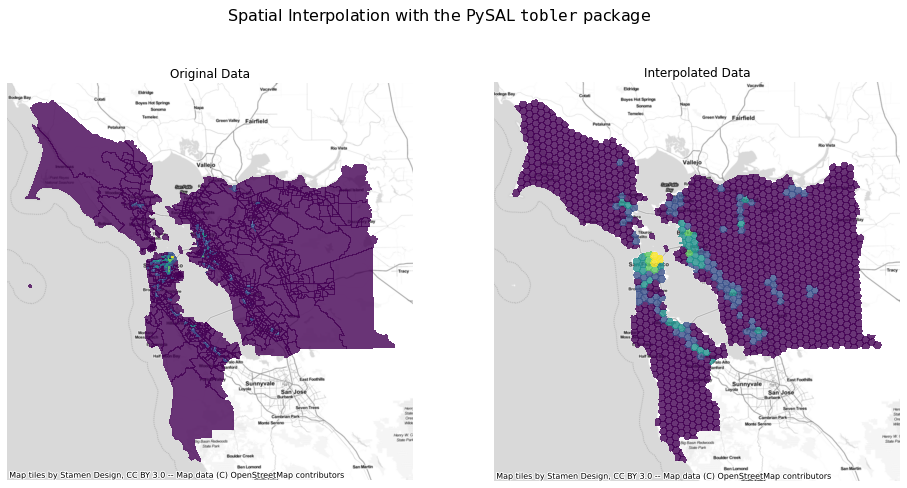

In [25]:
fig, axs = plt.subplots(1,2, figsize=(16, 8))

tracts_proj.plot(
    'store_density', scheme='fisherjenks', alpha=0.8, ax=axs[0], edgecolor='none', antialiased=False)
hex_interpolated.plot(
    'store_density', scheme='fisherjenks', alpha=0.8, ax=axs[1], edgecolor='none', antialiased=False)

axs[0].set_title('Original Data')
axs[1].set_title('Interpolated Data')
           
for ax in axs:
    cx.add_basemap(
        ax=ax,
        source=cx.providers.Stamen.TonerLite,
        crs=hexes.crs.to_string())
    ax.axis('off')

fig.suptitle('Spatial Interpolation with the PySAL $\mathtt{tobler}$ package', fontsize=16)

plt.show()

Here we're interpolating the value of the density metric rather than the point counts. Why might it be a bad idea to interpolate the point counts?

For more examples of interpolation, and different interpolation methods, check out the `tobler` documentation [here](https://pysal.org/tobler/notebooks/01_interpolation_methods_overview.html) 

## 2.4. Dot-density maps -- alternative to choropleth

A useful alternative to the choropleth map which avoids both MAUP and aggregation bias is the dot-density map. These became very popular around the time of the 2010 Decennial Census due to a racial dot density map of Chicago made by Professor Bill Rankin (a.k.a. [Radical Cartography](http://www.radicalcartography.net/index.html?chicagodots))

<center><img src="http://www.radicalcartography.net/chicagodots_race_lines.jpg" width=500></center>

Some other really fascinating examples followed from the [Cooper Center](https://demographics.coopercenter.org/racial-dot-map) at the University of Virginia, and Bay Area cartographer [Erica Fischer](https://commons.wikimedia.org/wiki/Category:Race_and_Ethnicity_by_Eric_Fischer_(2010_Census_data))

Detroit


<center><img src="https://www.gannett-cdn.com/-mm-/c1fd377bdd190832b44b31a5c9345a838610929b/c=0-2-1489-843/local/-/media/2015/09/01/DetroitFreePress/DetroitFreePress/635767091539964541-race.JPG"></center>

To find out more about dot-density maps, what they do well and what they do not-so-well, check out the ever-useful Axis Maps cartography guide [here](https://www.axismaps.com/guide/dot-density)

### Exercise:

Rather than re-create the wheel, check out [this](http://andrewgaidus.com/Dot_Density_County_Maps/) step-by-step guide for creating dot density maps in Python. Copy-paste that code into this notebook and try to create your own!

# 3. Final project breakout groups

# 4. For next time

# 5. Questions?